In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Load the file in a Data Frame
file = 'GMM.txt'

if(file == 'GMM.txt'):
    df = pd.read_csv(file,sep=" ", header=None)
else:
    df = pd.read_csv(file,sep="\t", header=None)

In [2]:
#GMM training
def GMM_fit(k,  max_iterations, gene_data, mue, sigmaa, pie, smooth_value = 1e-9, conv_limit=1e-9):
    pie = sigmaa = mue = None
    if pie:
        pi = [np.asarray(x , dtype = float) for x in pie]
    else:
        pi = np.full(shape=k, fill_value=1/k)
    
    prob_clust = np.full(shape=gene_data.shape, fill_value=1/k)
    
    if mue:
        mu = [np.asarray(x , dtype = float) for x in mue]
    else:
        row_choice = np.random.randint(low=0, high=gene_data.shape[0], size = k)
        mu = [  gene_data[index,:] for index in row_choice ]
    if sigmaa:
        sigma = [np.asarray(x , dtype = float) for x in sigmaa]
    else:
        sigma = [ np.cov(gene_data.T) for _ in range(k) ]
        
    for i,x in enumerate(sigma):
        np.fill_diagonal(sigma[i], x.diagonal() + smooth_value)
    prev_loss = None
    
    for iteration in range(max_iterations):
        # E step
        prob_clust = prob_predict(k, gene_data, mu, sigma, pi)
        pi = prob_clust.mean(axis=0)
        
        # M step
        for i in range(k):
            wt = prob_clust[:, [i]]
            total_wt = wt.sum()
            mu[i] = (gene_data * wt).sum(axis=0) / total_wt
            sigma[i] = np.cov(gene_data.T, aweights=(wt/total_wt).flatten(), bias=True)
            for i,x in enumerate(sigma):
                np.fill_diagonal(sigma[i], x.diagonal() + smooth_value)
                
        new_loss = loss_function(gene_data, prob_clust, mu, sigma, pi)
        if prev_loss != None and abs(new_loss - prev_loss) <= conv_limit:
            break
        
        prev_loss = new_loss
        
    return mu,sigma,pi
        

In [3]:
#GMM each data point probability prediction
def prob_predict(k, gene_data, mu, sigma, pi):
    likelihood = np.zeros( (gene_data.shape[0], k) )
    for i in range(k):
        distribution = multivariate_normal(mean=mu[i],cov=sigma[i])
        likelihood[:,i] = distribution.pdf(gene_data)
    num = likelihood * pi
    denom = num.sum(axis=1)[:, np.newaxis]
    prob_clust = num / denom
    return prob_clust

In [4]:
#GMM prediction
def GMM_predict(k,gene_data,mu, sigma, pi):
    prob_clust = prob_predict(k,gene_data,mu, sigma, pi)
    return np.argmax(prob_clust, axis=1)

In [5]:
#GMM loss function
def loss_function(gene_data, prob_clust, mu, sigma, pi):
    loss = np.zeros((gene_data.shape[0], prob_clust.shape[1]))
    for c in range(prob_clust.shape[1]):  
        dist = multivariate_normal(mu[c], sigma[c], allow_singular=True)
        loss[:,c] = prob_clust[:,c] * (np.log(pi[c]+0.00000001)+dist.logpdf(gene_data)-np.log(prob_clust[:,c]+0.000000001))
    loss = np.sum(loss)
    return loss

#Plotting the clusters
def plots(pca_data,assigned_cluster,file):
    df_new = pd.DataFrame({'y1':np.array(pca_data)[:,0], 'y2':np.array(pca_data)[:,1], 'clusters': assigned_cluster})
    sns.lmplot(x='y1', y='y2', data=df_new, fit_reg=False,hue='clusters',palette = 'dark', height=5,aspect = 1.5,legend_out = False)
    plt.title(file)

In [6]:
#Incident Matrix
def get_matrix(cluster_values):
    mat = np.zeros((len(cluster_values),len(cluster_values)))
    for i in range(len(cluster_values)):
        for j in range(len(cluster_values)):
                if(cluster_values[i] == cluster_values[j]):
                    mat[i][j] = 1
                else:
                    mat[i][j] = 0
    return mat

#Calculating m values using ground truth values and kmeans values
def external_index(ground_matrix, kmeans_matrix):
    m11 = 0
    m00 = 0
    m01 = 0
    m10 = 0
    for i in range(len(ground_matrix)):
        for j in range(len(kmeans_matrix)):
            if kmeans_matrix[i][j] == 1 and ground_matrix[i][j] == 1:
                m11 += 1
            elif kmeans_matrix[i][j] == 0 and ground_matrix[i][j] == 0:
                m00 += 1
            elif kmeans_matrix[i][j] == 0 and ground_matrix[i][j] == 1:
                m01 += 1
            elif kmeans_matrix[i][j] == 1 and ground_matrix[i][j] == 0:
                m10 += 1
    return m11, m00, m01, m10

Enter the number of clusters
3
Enter the maximum number of iterations
100
Enter the smooth_value
1e-9
Enter the Convergence thershold
1e-9
Enter the mue value
[[1, 1], [3.5, 5.3], [0, 4]]
Enter the sigma value
[[[1, 0.5], [0.5, 1]],[[1, 0], [0, 2]],[[0.5, 0], [0,0.1]]]
Enter the pi value
[0.1,0.8,0.1]
GMM Clustering Results for the K value 3 and Convergence threshold 1e-09
-------------------------------------------------------------
Rand Index for file GMM.txt is 0.95208
Jaccard Coefficient for file GMM.txt is 0.8733561672798004


Mu value after the 100 iterations is :
[[ 3.03125112e+00  3.00615490e+00]
 [-1.70394640e-02  3.95339043e+00]
 [ 8.51481886e-03 -2.37720425e-03]]
-------------------------------------------------------------
Sigma value after the 100 iterations is :
[[[ 0.96222522 -0.03618659]
  [-0.03618659  1.60614058]]

 [[ 0.46059986 -0.06042067]
  [-0.06042067  0.10632449]]

 [[ 0.92966186  0.37932812]
  [ 0.37932812  0.84677796]]]
---------------------------------------

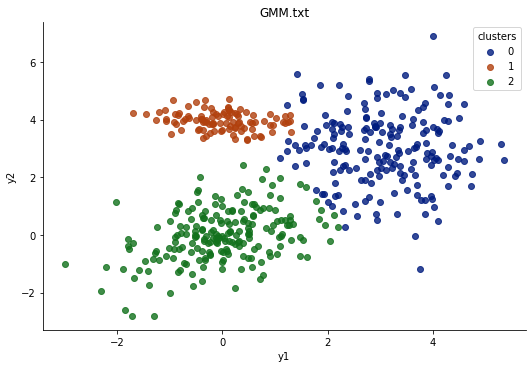

In [7]:
def __main__():
    print("Enter the number of clusters")
    k = int(input()) #2
    print("Enter the maximum number of iterations")
    max_iterations = int(input()) #10
    print("Enter the smooth_value")
    smooth_value = float(input()) #1e-9
    print("Enter the Convergence thershold")
    conv_limit = float(input())
    
    print('Enter the mue value')
    mu = list(input())
#     mu = [[0,0] ,[1,1]]
    print('Enter the sigma value')
#     sigma = [[[1,1],[1,1]],[[2,2],[2,2]]]
    sigma = list(input())
    print('Enter the pi value')
    pi = list(input())
#     pi = [0.5 , 0.5]

    #ground truth values
    gr_true_values = df[1]

    #Gene Data
    gene_data = df.iloc[:,2:].to_numpy().astype(np.float)

    mu, sigma, pi = GMM_fit(k, max_iterations, gene_data, mu, sigma, pi,smooth_value= smooth_value, conv_limit =conv_limit)

    #GMM Cluster Assignment
    cluster_assignment = GMM_predict(k,gene_data,mu, sigma, pi)

    cluster_assignment=np.asarray(cluster_assignment,dtype=int)

    #Since GMM has only two feature not performing PCA reduction
    if(file == 'GMM.txt'):
        pca_data = gene_data
    #PCA part
    else:
        pca_data = PCA(n_components=2).fit_transform(gene_data)

    #Scatter Plots
    plots(pca_data,cluster_assignment,file)

    #Incident Matrices for both Ground truth values and Kmeans Cluster values
    ground_matrix = get_matrix(gr_true_values.to_numpy())
    GMM_matrix = get_matrix(np.array(cluster_assignment))

    #External_indices
    m11,m00,m01, m10 = external_index(ground_matrix,GMM_matrix)

    #Rand Index
    rand_index = (m11 + m00)/(m11 + m00 + m01 + m10)

    #Jaccard Coefficient
    j_coeff = (m11)/(m11 + m10 + m01)

    print("GMM Clustering Results for the K value {} and Convergence threshold {}".format(str(k), str(conv_limit)))
    print("-------------------------------------------------------------")
    print("Rand Index for file {} is {}".format(file,str(rand_index)))
    print("Jaccard Coefficient for file {} is {}".format(file,str(j_coeff)))
    print("\n")
    print("Mu value after the {} iterations is :".format(max_iterations))
    print(np.array(mu))
    print("-------------------------------------------------------------")
    print("Sigma value after the {} iterations is :".format(max_iterations))
    print(np.array(sigma))     
    print("-------------------------------------------------------------")
    print("Pie value after the {} iterations is :".format(max_iterations))
    print(np.array(pi))
    

__main__()